# Redes Neuronales Artificiales - Trabajo Práctico 1

### Guillermina Cabrol, Magalí Giansiracusa, Sofía Goldberg



## Introducción

En este trabajo implementaremos modelos de redes neuronales artificiales para aprendizaje supervisado, para dos problemas distintos: **Diagnóstico de cáncer de mamas** y **Eficiencia energética**. Se hará un análisis de los datos obtenidos y los modelos construidos.

Las principales librerías que serán utilizadas para el desarrollo de los modelos son `Numpy` y `Matplotlib`. También usaremos `requests` para cargar los datos y `random` para generar seeds necesarias para que los resultados sean reproducibles.

In [5]:
import numpy as np 
from matplotlib import pyplot as plt
import requests
import random

Creamos una función para separar los datos en entrenamiento (`train`), validación (`val`) y testeo (`test`). Como sus nombres indican, usaremos los datos de entrenamiento para entrenar la red, los de validación para comprobar qué tan bien predice la red para datos no utilizados en el entrenamiento y poder ajustar parámetros para mejorar la performance, y por último, usaremos el dataset de testeo para calificar el modelo final y estimar su desempeño en la realidad.

In [6]:
from math import ceil, floor

def split(
        X: np.ndarray,
        Z: np.ndarray,
        train_size: float,
        val_size: float,
        test_size: float,
    ) -> tuple:

    """Separa el conjunto de datos en conjuntos de train, validation y test al azar.

    Parameters
    ----------
    X: datos de entrada.
    
    Z: datos objetivo.
    
    train_size: proporción del dataset a incluir en train.

    val_size: proporción del dataset a incluir en validation.

    test_size: proporción del dataset a incluir en test.

    random_state: sirve para que los resultados sean reproducibles.

    Returns
    -------
    split: lista que contiene el conjunto de test y el de train.
    """

    n = len(X)

    n_test = ceil(test_size * n)
    n_train = floor(train_size * n)
    n_val = ceil(val_size * n)

    n_train, n_test, n_val = int(n_train), int(n_test), int(n_val)


    X_train = X[:n_train]
    X_val = X[n_train:n_train + n_test]
    X_test = X[n_train + n_test:]

    Z_train = Z[:n_train]
    Z_val = Z[n_train:n_train + n_test]
    Z_test = Z[n_train + n_test:]

    return X_train, Z_train, X_val, Z_val, X_test, Z_test

## Diagnóstico de cáncer de mamas

Tenemos un conjunto de datos con los resultados para distintos pacientes de un examen para determinar si tienen cáncer de mamas maligno o benigno. Cada columna representa una característica obtenida en el examen realizado, y el objetivo será determinar si es posible predecir el diagnóstico final utilizando una red neuronal.

Primero, cargamos los datos, y los separamos en X (datos de entrada) y Z (datos objetivo).

In [7]:
r = requests.get('https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp1_ej1_training.csv')
data = np.loadtxt(r.iter_lines(), delimiter=',')

data = np.random.RandomState(seed=42).permutation(data)

X1 = data[:,1:]

Z1 = data[:,0:1]

Dividimos los datos:

- 80% para entrenamiento.
- 15% para validación.
- 5% para testeo.

In [8]:
X_train1, Z_train1, X_val1, Z_val1, X_test1, Z_test1 = split(X1, Z1, 0.8, 0.15, 0.05)

### Análisis de datos

Vamos a realizar un análisis de los datos de entrenamiento para ver su distribución y cuán correlacionados están, para así decidir si es necesario realizar alguna modificación.

Para esto, pasaremos los datos a formato *DataFrame* usando la librería `Pandas`.

In [9]:
import pandas as pd

df = pd.DataFrame(X_train1, columns=['Radio', 'Textura', 'Perímetro', 'Área', 'Suavidad', 'Compacidad', 'Concavidad', 'Puntos cóncavos', 'Simetría', 'Dimensión fractal'])
df

Radio  Textura  Perímetro      Área  Suavidad  Compacidad  Concavidad   
0    20.284   13.181    158.656  1179.240     1.205       1.878       4.898  \
1    18.298   11.596    154.492  1370.281     0.933       1.291       5.229   
2    23.810   26.490     48.872   740.533     1.970       2.042       0.427   
3    25.137   15.136     94.484   694.296     1.594       0.683       1.846   
4    25.586   12.223    147.360  1598.108     0.816       1.121       3.131   
..      ...      ...        ...       ...       ...         ...         ...   
323  25.037   18.467     78.939   371.967     1.770       1.504       1.338   
324  20.723   26.535     90.812   742.614     1.972       1.682       2.265   
325  18.179   13.237    152.105  1134.127     1.239       1.893       5.015   
326  17.415   22.883     83.133   366.730     1.783       2.640       2.928   
327  16.014   28.302     85.181   969.770     2.177       1.208       3.646   

     Puntos cóncavos  Simetría  Dimensión fractal  
0              5.932     1.029              2.019  
1              6.866     0.760              2.164  
2              0.434     0.651              0.267  
3              2.414     0.784              0.830  
4              2.793     0.814              1.933  
..               ...       ...                ...  
323            1.802     0.768              0.579  
324            2.119     0.843              1.098  
325            6.325     0.572              2.340  
326            4.197     0.394              1.249  
327            5.480     1.217              0.593  

[328 rows x 10 columns]

Realizamos un gráfico usando la librería `seaborn` para visualizar mejor cómo se relacionan los datos y cuáles son los valores de los mismos.

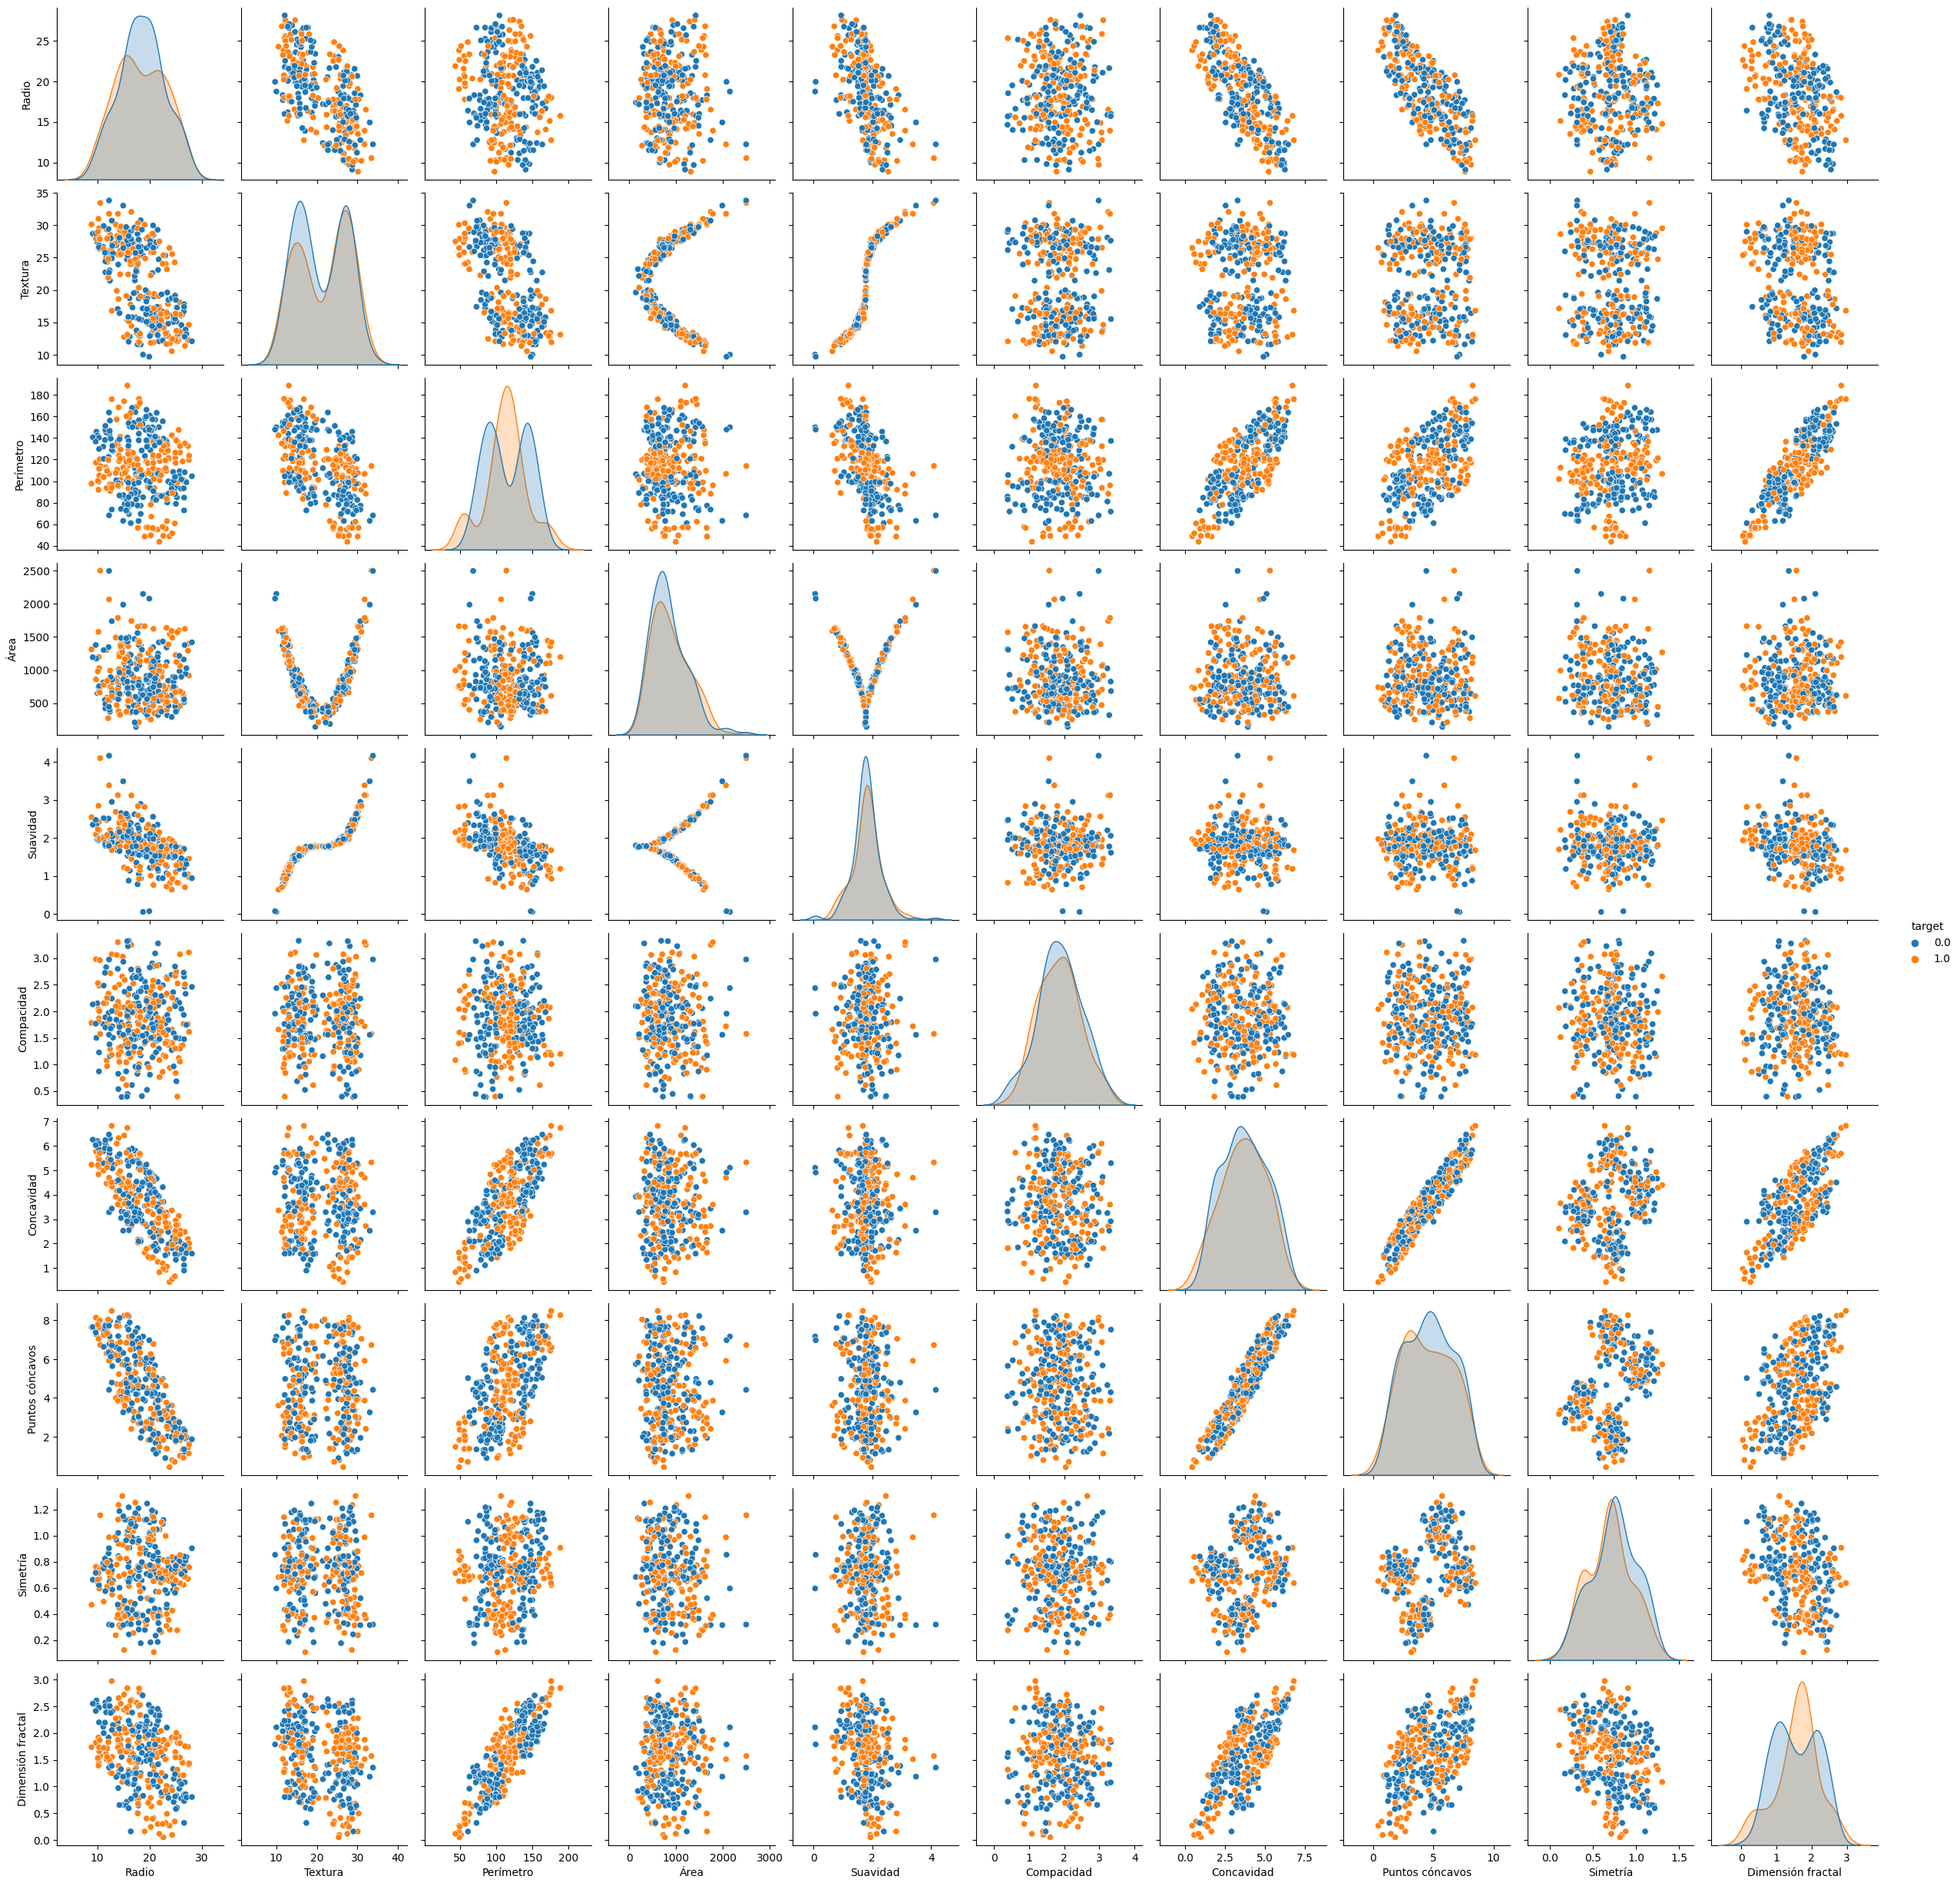

In [10]:
import seaborn as sns

sns.pairplot(df.assign(target=Z_train1), hue="target")

Como se ve claramente en el gráfico, los datos de entrada presentan magnitudes diferentes entre sí, por lo que vamos a necesitar estandarizarlos, para lo cual le restamos a cada instancia su media y dividimos por su desvío estándar. Esto lo hacemos para tanto el conjunto de entrenamiento como el de test y el de validación, pero a éstos últimos se les resta la media y se divide por la varianza de los datos de entrenamiento, para no TODO.

In [11]:
X_train1 = (X_train1 - X_train1.mean(axis=0)) / X_train1.std(axis=0)
X_test1 = (X_test1 - X_train1.mean(axis=0)) / X_train1.std(axis=0)
X_val1 = (X_val1 - X_train1.mean(axis=0)) / X_train1.std(axis=0)

Ahora las escalas de los datos ya no son tan distintas entre sí, como se puede ver en el siguiente gráfico:

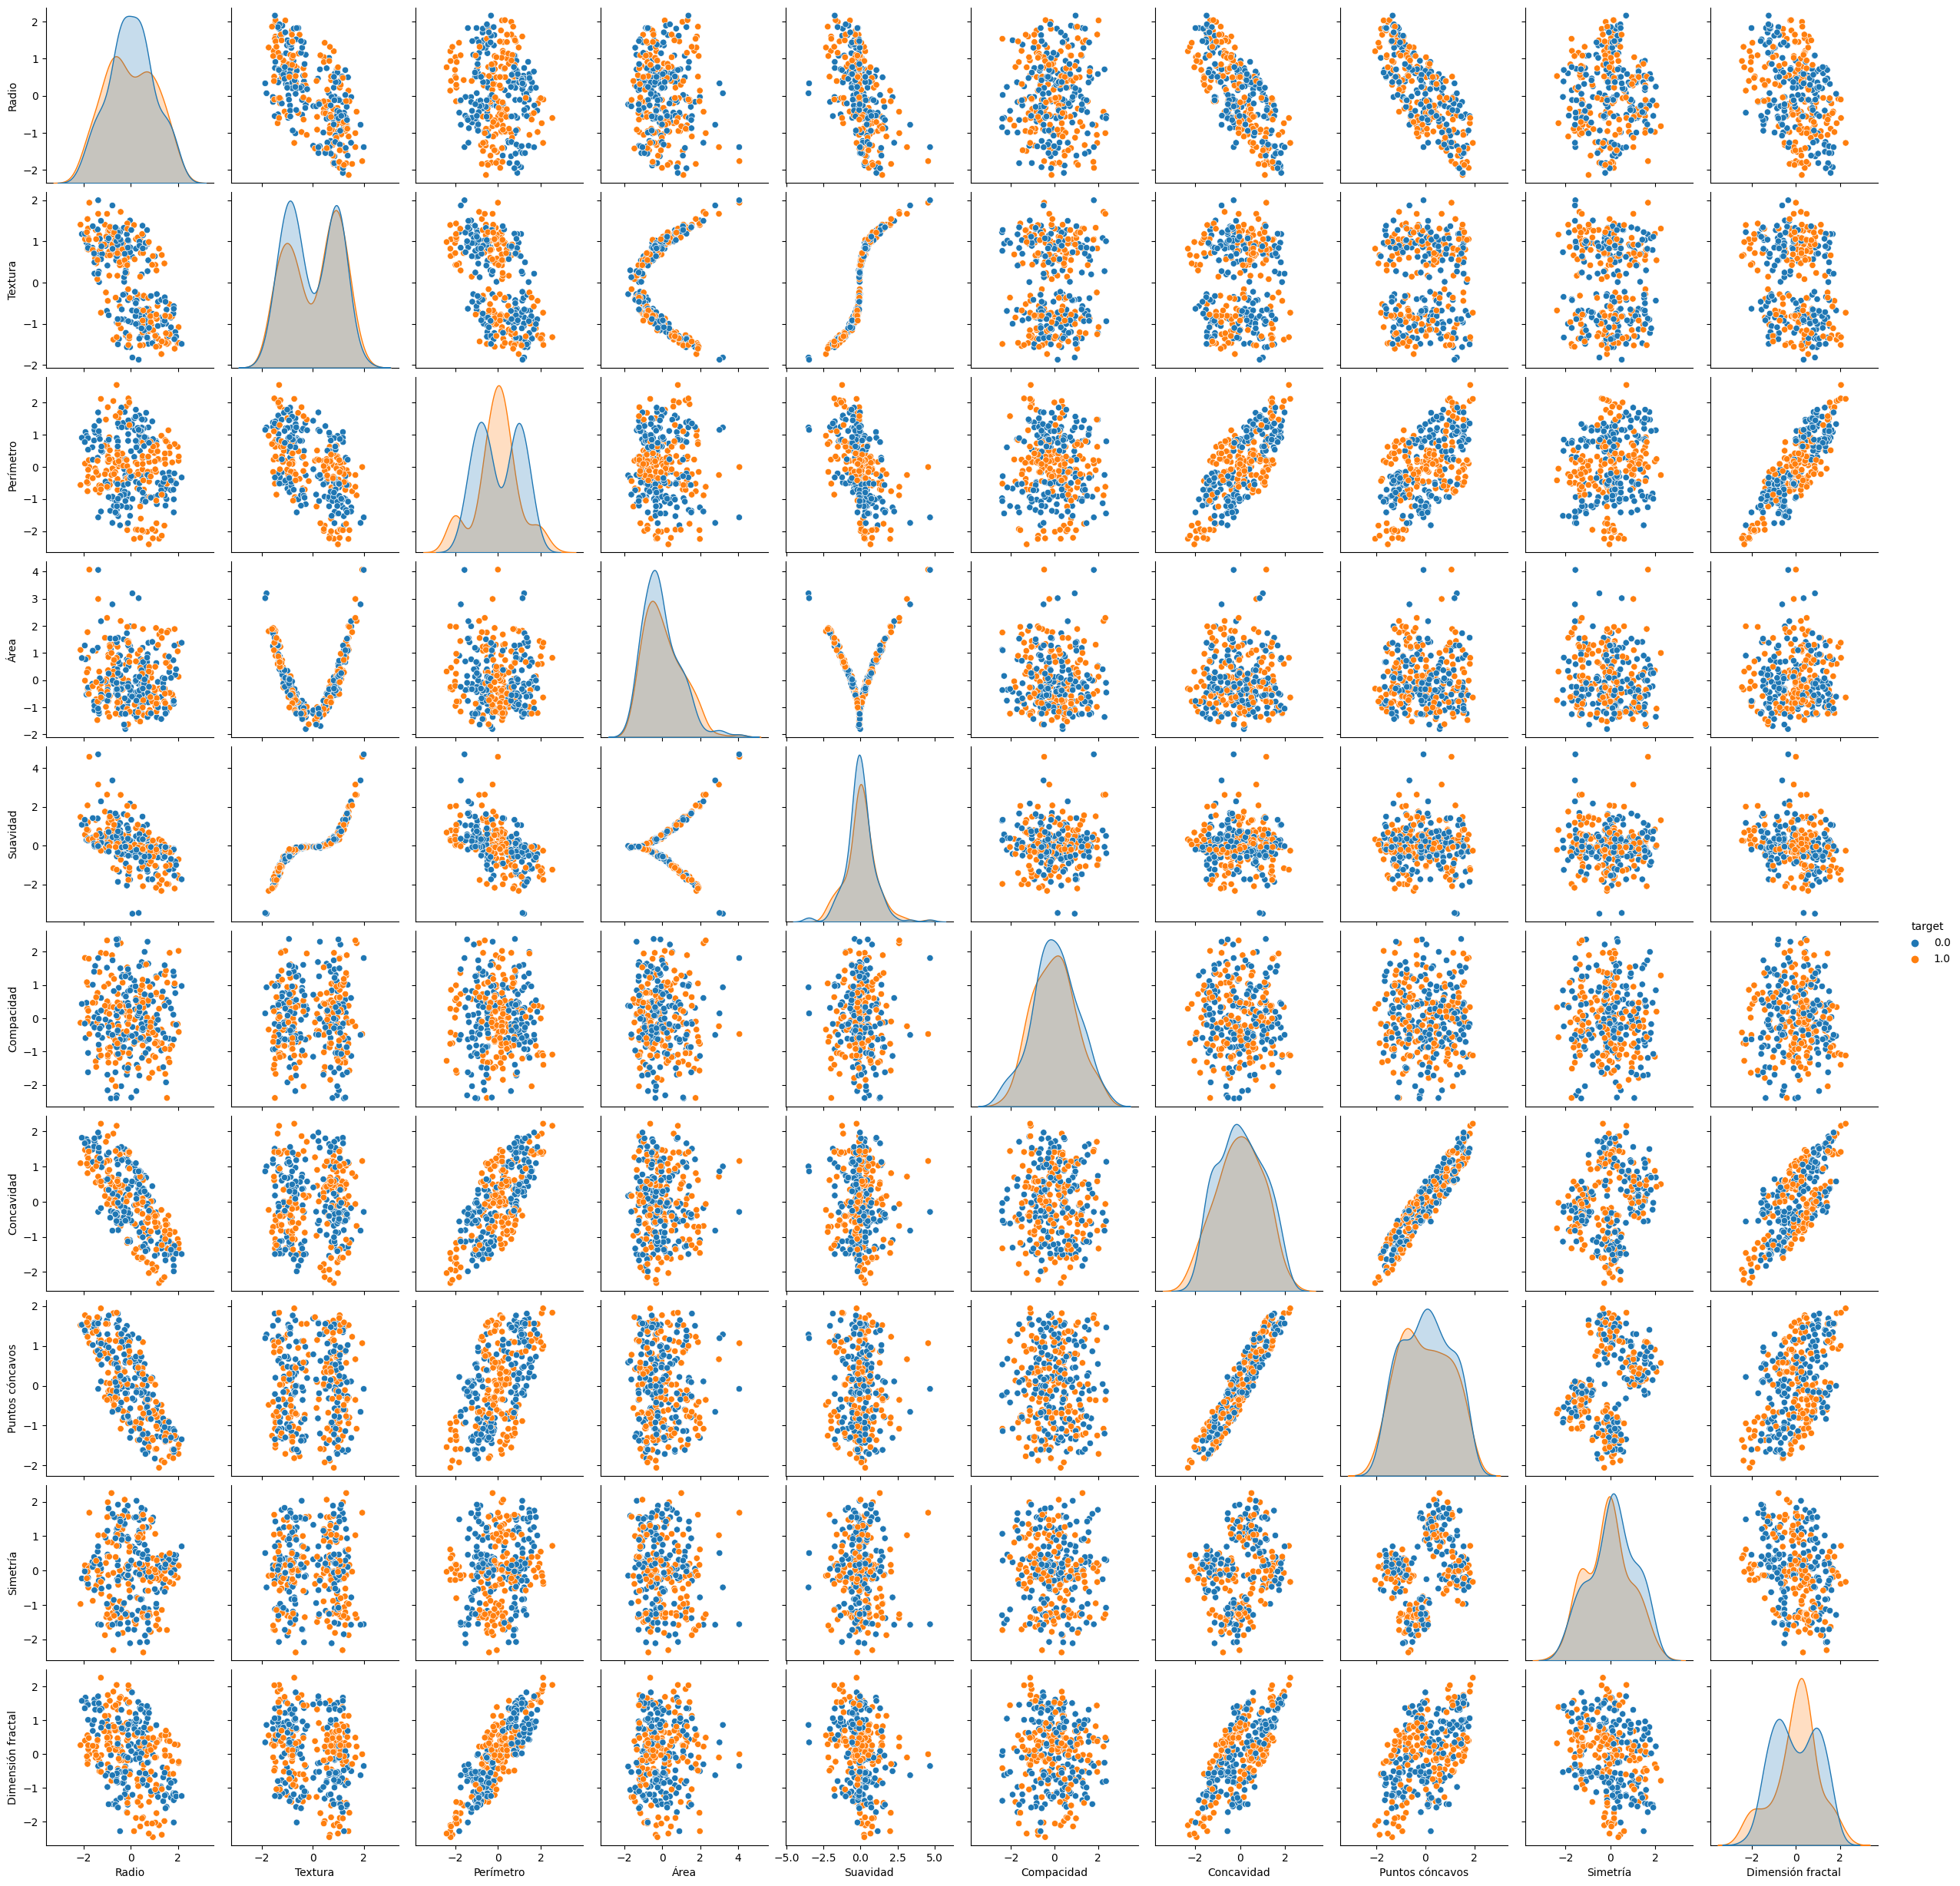

In [12]:
import seaborn as sns
df = pd.DataFrame(X_train1, columns=['Radio', 'Textura', 'Perímetro', 'Área', 'Suavidad', 'Compacidad', 'Concavidad', 'Puntos cóncavos', 'Simetría', 'Dimensión fractal'])
sns.pairplot(df.assign(target=Z_train1), hue="target")

A continuación, definimos la clase del modelo a utilizar, en el cual vamos a variar la cantidad de capas de la red y la distribución de nodos por capa para obtener intentar obtener una red neuronal que prediga el diagnóstico final.

In [58]:
P = X_train1.shape[0]    # cantidad de instancias
N = 10                  # unidades de entrada
M = 1                   # unidades de salida
S = [N, 5, 9, M]       # distribución de nodos por capa

Para resolver el ejercicio, implementaremos una red neuronal artificiañmulticapa(Multilayer Perceptron). En el MPL, las neuronas están organizadas en capas y cada una de ellas está conectada a las neuronas de la siguiente capa.

En este caso, tenemos 10 unidades de entrada en la primer capa, 2 capas ocultas con 5 unidades y una última capa de salida con 1 unidad.  La red neuronal se entrenará utilizando el conjunto de datos de entrenamiento con P instancias.

In [39]:
class MLPCancerDeMamas:
    def __init__(self, units_per_layers):
        self.batch_size = 20
        #self.batch_size = batch_size
        self.S = units_per_layers
        self.L = len(self.S)
        self.Y = []
        self.W = self._initialize_W()  
        self.dW = self._initialize_dW() 
        self.lr = 1e-2
        #self.lr = lr

    def activation(self, X):
        self.Y = self._initialize_Y(X)
        activation = X

        for k in range(1, self.L):
            self.Y[k-1][:,:] = self._bias_add(activation)
            activation = np.tanh(self.Y[k-1] @ self.W[k])
        
        self.Y[self.L - 1] = activation

        return self.Y
    
    def correction(self, Z):
        E = Z - self.Y[self.L - 1]
        dY = 1 - np.square(self.Y[self.L - 1])

        D = [ np.empty_like(y) for y in self.Y]
        D[self.L-1] = E*dY

        for k in range(self.L-1, 0, -1):
            self.dW[k] = self.lr * (self.Y[k-1].T @ D[k])
            E = D[k] @ self.W[k].T
            dY = 1 - np.square(self.Y[k-1])
            D[k-1] = self._bias_sub(E*dY)
        return self.dW
    
    def adaptation(self):
        for k in range(1, self.L):
            self.W[k] += self.dW[k]
        return self.W
    
    def estimation(self, Z):
        return np.mean(np.square(Z - self.Y[self.L - 1]))
        

    def train(self, X, Z, epochs):
        t = 0
        errores = []
        while t < epochs:
            e = 0
            indices = np.random.permutation(len(X))
            for h in range(0, len(indices), self.batch_size):
                batch = indices[h:h + self.batch_size]
                Xh = X[batch]
                Zh = Z[batch]
                self.Y = self.activation(Xh)
                e += self.estimation(Zh)
                self.dW = self.correction(Zh)
                self.W = self.adaptation()

            errores.append(e)
            t += 1
            if t % 100 == 0:
                print(t, e)
        plt.plot(errores, 'r')
        plt.show()

        return self.W

    def validation(self, X):
        self.activation(X)

    ## Funciones privadas

    def _bias_add(self, V):
        bias = np.ones((len(V), 1))
        return np.hstack([V, bias])


    def _bias_sub(self, V):
        return V[:,:-1]
    
    def _initialize_Y(self, X):
        P = len(X)
        Y = [ np.empty((P, S[i]+1)) for i in range(self.L)]
        Y[self.L-1] = np.empty((P, S[self.L - 1]))
        return Y

    def _initialize_W(self):
        W = []
        W.append(np.array([]))
        W.extend(np.random.RandomState(seed=42).normal(0, 0.5, (self.S[i-1] + 1, self.S[i])) for i in range(1,self.L)) 
        return W

    def _initialize_dW(self): 
        dW = [np.empty_like(w) for w in self.W ]
        return dW

En primer lugar, el constructor de la clase inicializa las variables necesarias para la red neuronal. Estas son:  el tamaño del lote (batch_size), el número de capas (L), las salidas de cada capa (Y), los pesos de las conexiones (W), el gradiente de los pesos (dW) y la tasa de aprendizaje (lr).

En la activación, se itera a través de las capas de la red y se utiliza la función tanh (tangente hiperbólica) para calcular la activación. En cada iteración, se guarda el valor de activación de las unidades en Yk.

En la corrección, se realiza la retro-propagación del error. Se calcula E, el error entre la salidad de la red neuronal y los objetivos(parámetro que recibe), y luego calcula los gradientes de las salidas de cada capa, para así calcular el gradiente de los pesos. Además, en cada iteración, se calcula la derivadad de la función de transferencia. Cuando esto se termina de ejecutar, se realiza la propagación del error hacia atrás para calcular la estimación del error

En la adaptación, se itera a través de las capas y actualiza los pesos (W) agregando el gradiente de los pesos (dW) multiplicado por la tasa de aprendizaje (lr).

En la estimación, se calcula el error cuadrático medio entre las salidas de la red neuronal y los objetivos. 

En el entrenamiento, la red neuronal se entrena utilizando el algoritmo de retropropagación durante un número especificado de épocas. Las épocas remiten a  la cantidad de veces que la red neuronal completa un paso de entrenamiento utilizando todo el conjunto de entrenamiento.
Para que se recorran las instancias en orden aleatorio sin repetición, utilizamos el método permutation.
Se itera a través de las épocas (mientras que la época sea menor que la época máxima) y, en cada época, realiza el entrenamiento en mini lotes. Los mini lotes consisten en a división del conjunto de entrenamiento en lotes más pequeños para entrenar la red neuronal de manera incremental.


En cada iteración, se calcula el error acumulado (e), realiza la corrección de la red neuronal utilizando la función correction, realiza la adaptación de los pesos utilizando la función adaptation y registra los errores en una lista.

Por último, decidimos implementar funciones privadas,las cuales van a ser utilizadas internamente por las funciones anteriormente descriptas y toman el rol de inicializar distintas variables y manipular los datos durante el proceso de entrenamiento y retropropagación del error de la red neuronal.






In [71]:
S_values = [[10, 5, 5, 1], [10, 10, 10, 1], [20, 10, 5, 1]]  # Ejemplo de valores para S
b_size_values = [10, 20, 30]  # Ejemplo de valores para b_size
lr_values = [1e-2, 1e-3, 1e-4]  # Ejemplo de valores para lr

# Definir los parámetros para el grid search
params = {
    'S': S_values,
    'b_size': b_size_values,
    'lr': lr_values
}

def grid_search(X_train, Z_train, params):
    
    for S in params['S']:
        for b_size in params['b_size']:
            for lr in params['lr']:
                modelo = MLPCancerDeMamas(S)
                modelo.b_size = b_size
                modelo.lr = lr
                modelo.train(X_train, Z_train, 2000)

                #score = modelo.estimation(Z_val)
                
                

grid_search(X_train1, Z_train1, params)



ValueError: could not broadcast input array from shape (20,6) into shape (20,8)

100 0.8811579939263608
200 0.5918618474202593
300 0.4409819273092032
400 0.33915734815458093
500 0.27177746391790897
600 0.23117595308164968
700 0.18517505495417302
800 0.15203052938311892
900 0.11858042764009305
1000 0.08473543671446074
1100 0.0642025238215383
1200 0.05920363882411536
1300 0.047603280674470824
1400 0.039074118416254855
1500 0.03641520446864435
1600 0.02947432649743396
1700 0.0290044228496871
1800 0.02486006375499622
1900 0.022215626865026334
2000 0.020895544941615423


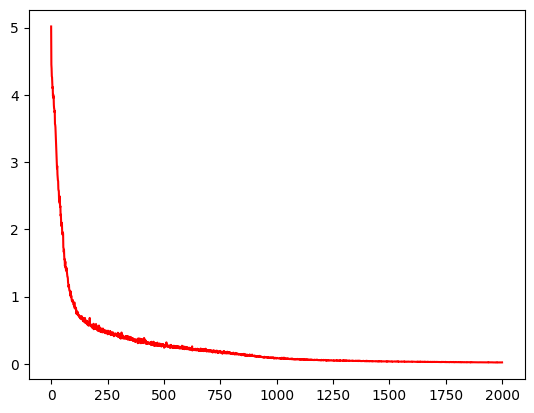

[array([], dtype=float64),
 array([[-2.99448956e-01, -3.53113801e-02,  6.12125516e-01,
          2.44199237e+00, -2.96260188e-01,  1.72856797e-01,
          1.35917195e+00],
        [ 9.97242511e-01, -4.24135770e-01,  8.23487303e-01,
         -2.15743805e+00,  2.64652091e-01, -2.45635730e-01,
         -1.60694402e+00],
        [-1.34877311e+00,  1.36165940e+00, -3.60244843e-01,
          8.28576382e-01, -5.02385718e-01, -1.02403331e+00,
          8.46300359e-01],
        [ 1.86539602e-01,  2.56652053e-01, -4.58422078e-01,
         -2.17012975e-01, -6.26092132e-01,  1.17312623e-04,
         -1.23908869e-01],
        [-8.62063677e-01,  3.02703908e-01,  5.18674023e-01,
          2.10395785e+00, -5.22289280e-01, -4.85074518e-02,
          1.66195162e+00],
        [-3.70393679e-01,  2.92767672e-01,  1.94291088e-01,
          2.16120763e-02,  2.73522228e-01,  4.52224341e-02,
          7.56407147e-02],
        [-1.57817891e-01,  6.99572508e-01, -8.63840779e-01,
         -1.05727291e+00, -7.43

In [72]:
S= [10,7,6,1]
modelo = MLPCancerDeMamas(S)
modelo.train(X_train1, Z_train1, 2000)

In [64]:
modelo.validation(X_val1)
error = modelo.estimation(Z_val1)
print(f"El error estimado para nuestro modelo es de: {error}")

El error estimado para nuestro modelo es de: 0.6658729504452549


## Eficiencia de energía

Tenemos los datos de un análisis energético realizado en varios edificios, con 10 característica cada uno. A diferencia del caso anterior, donde el problema era de clasificación (decidir entre dos etiquetas, a cuál pertenece cada instancia), en este caso tenemos un problema de regresión: se quieren predecir dos valores: **Carga de calefacción** y **Carga de refrigeración**, los cuales representan la carga energética necesaria para la calefacción y refrigeración de un edificion.

El objetivo es el mismo, encontrar determinar si hay un modelo de redes neuronales que prediga la carga energética.

Cargamos los datos, y los separamos en X (datos de entrada) y Z (datos objetivo).

In [11]:
r = requests.get('https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp1_ej2_training.csv')
data = np.loadtxt(r.iter_lines(), delimiter=',')

data = np.random.RandomState(seed=42).permutation(data)

X2 = data[:,:-2]

Z2 = data[:,[-2,-1]] 

Dividimos los datos en train, validation y test, con las mismas proporciones que en la sección anterior.

In [12]:
X_train2, Z_train2, X_val2, Z_val2, X_test2, Z_test2 = split(X2, Z2, 0.8, 0.15, 0.05)

In [13]:
df = pd.DataFrame(X_train2, columns=['Compacidad Relativa', 'Área de la Superficie Total', 'Área de las Paredes', 'Área del techo', 'Altura Total', 'Orientación', 'Área de Reflejo Total', 'Distribución del Área de Reflejo'])
df

Compacidad Relativa  Área de la Superficie Total  Área de las Paredes   
0                   0.86                        588.0                294.0  \
1                   0.90                        563.5                318.5   
2                   0.62                        808.5                367.5   
3                   0.71                        710.5                269.5   
4                   0.76                        661.5                416.5   
..                   ...                          ...                  ...   
395                 0.86                        588.0                294.0   
396                 0.79                        637.0                343.0   
397                 0.98                        514.5                294.0   
398                 0.69                        735.0                294.0   
399                 0.62                        808.5                367.5   

     Área del techo  Altura Total  Orientación  Área de Reflejo Total   
0            147.00           7.0          3.0                   0.10  \
1            122.50           7.0          3.0                   0.25   
2            220.50           3.5          2.0                   0.25   
3            220.50           3.5          4.0                   0.10   
4            122.50           7.0          2.0                   0.25   
..              ...           ...          ...                    ...   
395          147.00           7.0          2.0                   0.40   
396          147.00           7.0          5.0                   0.25   
397          110.25           7.0          4.0                   0.40   
398          220.50           3.5          3.0                   0.25   
399          220.50           3.5          2.0                   0.25   

     Distribución del Área de Reflejo  
0                                 3.0  
1                                 2.0  
2                                 3.0  
3                                 4.0  
4                                 1.0  
..                                ...  
395                               5.0  
396                               1.0  
397                               4.0  
398                               1.0  
399                               2.0  

[400 rows x 8 columns]

In [14]:
X_train2 = (X_train2 - X_train2.mean(axis=0)) / X_train2.std()
X_test2 = (X_test2 - X_train2.mean(axis=0)) / X_train2.std()
X_val2 = (X_val2 - X_train2.mean(axis=0)) / X_train2.std()

In [15]:
df = pd.DataFrame(X_train2, columns=['Compacidad Relativa', 'Área de la Superficie Total', 'Área de las Paredes', 'Área del techo', 'Altura Total', 'Orientación', 'Área de Reflejo Total', 'Distribución del Área de Reflejo'])
df

Compacidad Relativa  Área de la Superficie Total  Área de las Paredes   
0               0.000430                    -0.374159            -0.107168  \
1               0.000604                    -0.480530            -0.000798   
2              -0.000612                     0.583177             0.211944   
3              -0.000221                     0.157695            -0.213539   
4              -0.000004                    -0.055047             0.424685   
..                   ...                          ...                  ...   
395             0.000430                    -0.374159            -0.107168   
396             0.000126                    -0.161418             0.105573   
397             0.000951                    -0.693271            -0.107168   
398            -0.000308                     0.264065            -0.107168   
399            -0.000612                     0.583177             0.211944   

     Área del techo  Altura Total  Orientación  Área de Reflejo Total   
0         -0.133495      0.007712    -0.001780              -0.000557  \
1         -0.239866      0.007712    -0.001780               0.000094   
2          0.185617     -0.007484    -0.006122               0.000094   
3          0.185617     -0.007484     0.002562              -0.000557   
4         -0.239866      0.007712    -0.006122               0.000094   
..              ...           ...          ...                    ...   
395       -0.133495      0.007712    -0.006122               0.000745   
396       -0.133495      0.007712     0.006903               0.000094   
397       -0.293051      0.007712     0.002562               0.000745   
398        0.185617     -0.007484    -0.001780               0.000094   
399        0.185617     -0.007484    -0.006122               0.000094   

     Distribución del Área de Reflejo  
0                            0.001118  
1                           -0.003224  
2                            0.001118  
3                            0.005460  
4                           -0.007565  
..                                ...  
395                          0.009801  
396                         -0.007565  
397                          0.005460  
398                         -0.007565  
399                         -0.003224  

[400 rows x 8 columns]

In [16]:
P = X_train2.shape[0]
N = 8                # unidades de entrada
M = 2                 # unidades de salida
S = [N, 10, 5, 30, 8, M]       # distribución de nodos por capa

In [17]:
class MLPEficienciaDeEnergia:
    def __init__(self, units_per_layers):
        self.batch_size = 20
        self.S = units_per_layers
        self.L = len(self.S)
        self.Y = []
        self.W = self._initialize_W()  
        self.dW = self._initialize_dW() 
        self.lr = 1e-2

    def activation(self, X):
        self.Y = self._initialize_Y(X)
        activation = X

        for k in range(1, self.L):
            self.Y[k-1][:,:] = self._bias_add(activation)
            activation = np.tanh(self.Y[k-1] @ self.W[k])
        
        self.Y[self.L - 1] = activation

        return self.Y
    
    def correction(self, Z):
        E = Z - self.Y[self.L - 1]
        dY = 1 - np.square(self.Y[self.L - 1])

        D = [ np.empty_like(y) for y in self.Y]
        D[self.L-1] = E*dY

        for k in range(self.L-1, 0, -1):
            self.dW[k] = self.lr * (self.Y[k-1].T @ D[k])
            E = D[k] @ self.W[k].T
            dY = 1 - np.square(self.Y[k-1])
            D[k-1] = self._bias_sub(E*dY)
        return self.dW
    
    def adaptation(self):
        for k in range(1, self.L):
            self.W[k] += self.dW[k]
        return self.W
    
    def estimation(self, Z):
        return np.mean(np.square(Z - self.Y[self.L - 1]))


    def train(self, X, Z, epochs):
        t = 0
        errores = []
        while t < epochs:
            e = 0
            indices = np.random.permutation(len(X))
            for h in range(0, len(indices), self.batch_size):
                batch = indices[h:h + self.batch_size]
                Xh = X[batch]
                Zh = Z[batch]
                self.Y = self.activation(Xh)
                e += self.estimation(Zh)
                self.dW = self.correction(Zh)
                self.W = self.adaptation()

            errores.append(e)
            t += 1
            if t % 100 == 0:
                print(t, e)
        plt.plot(errores, 'r')
        plt.show()

        return self.W

    def validation(self, X):
        self.activation(X)

    ## Funciones privadas

    def _bias_add(self, V):
        bias = np.ones((len(V), 1))
        return np.hstack([V, bias])


    def _bias_sub(self, V):
        return V[:,:-1]
    
    def _initialize_Y(self, X):
        P = len(X)
        Y = [ np.empty((P, S[i]+1)) for i in range(self.L)]
        Y[self.L-1] = np.empty((P, S[self.L - 1]))
        return Y

    def _initialize_W(self):
        W = []
        W.append(np.array([]))
        W.extend(np.random.RandomState(seed=42).normal(0, 0.5, (self.S[i-1] + 1, self.S[i])) for i in range(1,self.L)) 
        return W

    def _initialize_dW(self): 
        dW = [np.empty_like(w) for w in self.W ]
        return dW

100 11780.58484984483
200 11780.584843478882
300 11780.584838636116
400 11780.584834879122
500 11780.584831913206
600 11780.584829534735
700 11780.584827600034
800 11780.584826005828
900 11780.584824676704
1000 11780.584823556672
1100 11780.584822603625
1200 11780.584821785447
1300 11780.584821077335
1400 11780.58482045993
1500 11780.584819917945
1600 11780.584819439197
1700 11780.584819013862
1800 11780.584818633984
1900 11780.584818293042
2000 11780.584817985651


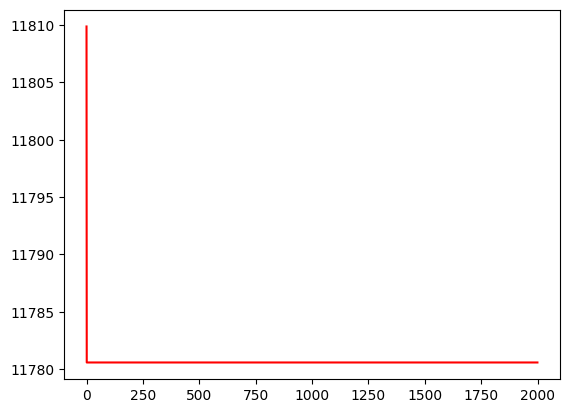

[array([], dtype=float64),
 array([[ 0.2487434 , -0.06967091,  0.32455436,  0.76271737, -0.11704463,
         -0.11654258,  0.78885259,  0.38315411, -0.23411401,  0.27253624],
        [-0.64873792,  0.35778118, -0.6684353 , -2.29005741, -0.88953527,
         -0.86367877,  0.32534115,  0.76707269, -1.1362926 , -2.14320716],
        [ 0.785522  , -0.27544356,  0.38652032, -0.23187599, -0.15520321,
          0.26839552, -0.84238805,  0.09369606,  0.00990933,  0.4428684 ],
        [-0.53571665,  1.30273982, -0.57783494, -1.43581316,  0.3392402 ,
         -1.00815644,  0.65375579, -0.62778407, -1.16034764, -0.91445468],
        [ 0.38236978,  0.06498265, -0.02806832, -0.10214611, -0.73648512,
         -0.33859793, -0.25963291,  0.50909143,  0.19724159, -0.82768085],
        [ 0.1614457 , -0.19084317, -0.33987096,  0.30295858,  0.51474403,
          0.46448478, -0.41698817, -0.15434967,  0.16400994,  0.48412228],
        [-0.2397394 , -0.09276082, -0.55339212, -0.59852285,  0.40644743,
     

In [18]:
modelo = MLPEficienciaDeEnergia(S)
modelo.train(X_train2, Z_train2, 2000)